# Importation des librairies et des données

In [1]:
# importation des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
# importation des données

data_2015 = pd.read_csv("2015-building-energy-benchmarking.csv", index_col="OSEBuildingID")
data_2016 = pd.read_csv("2016-building-energy-benchmarking.csv", index_col="OSEBuildingID")

# Préparation des données

In [3]:
# il est nécessaire de renommer la colonnes des émissions dans les données 2015

names = {"GHGEmissions(MetricTonsCO2e)" : "TotalGHGEmissions"}

data_2015.rename(columns=names, inplace=True)

In [4]:
# sélection des observations pour lesquelles ComplianceStatus est Compliant

data_2015 = data_2015.loc[data_2015["ComplianceStatus"]=="Compliant"]
data_2016 = data_2016.loc[data_2016["ComplianceStatus"]=="Compliant"]

In [5]:
# attributs indispensables

essential_features = ["PropertyGFABuilding(s)", "SourceEUI(kBtu/sf)", "SiteEnergyUse(kBtu)", "TotalGHGEmissions"]

data_2015.dropna(subset=essential_features, inplace=True)
data_2016.dropna(subset=essential_features, inplace=True)

In [6]:
# on ne retient que certaines les colonnes numériques ou catégorielles utiles

num_col = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking",
           "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
           "ThirdLargestPropertyUseTypeGFA", "ENERGYSTARScore", "SourceEUI(kBtu/sf)", "SiteEnergyUse(kBtu)",
           "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)", "TotalGHGEmissions"]

obj_col = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType",
           "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

use_col = num_col + obj_col

In [7]:
# on compile les bâtiments présents uniquement en 2015 avec ceux de 2016

id_2016 = data_2016.index
data_only_2015 = data_2015[~data_2015.index.isin(id_2016)]
data = pd.concat([data_only_2015[use_col], data_2016[use_col]])


In [8]:
# création de SourceEnergyUse qui correspond au produit de PropertyGFABuilding(s) et SourceEUI(kBtu/sf)

data = data.assign(SourceEnergyUse = data["PropertyGFABuilding(s)"] * data["SourceEUI(kBtu/sf)"])

In [9]:
# création de ElectricityUse, GasUse, SteamUse, OtherUse
# qui correspondent à l'utilisation de chacune de ces énergies
# de 0 (pas du tout ou de façon négligeable) à 4 (principale) en considérant un rapport significatif de 1.3

def energy_ranking(line) :
    dict_energy = { "ElectricityUse" : line["Electricity(kBtu)"] / line["SiteEnergyUse(kBtu)"],
                  "GasUse" : line["NaturalGas(kBtu)"] / line["SiteEnergyUse(kBtu)"],
                  "SteamUse" : line["SteamUse(kBtu)"] / line["SiteEnergyUse(kBtu)"],
                  "OtherUse" : 1-(line["Electricity(kBtu)"]+line["NaturalGas(kBtu)"]+line["SteamUse(kBtu)"])/line["SiteEnergyUse(kBtu)"]}
    
    ranked = []
    for energy, rate in dict_energy.items() :
        if rate < 0.05 :
            line[energy] = 0
        else :
            ranked.append((energy,rate))
    ranked = sorted(ranked, key=lambda x:x[1], reverse=True)
    importance = 4
    i = 0
    
    while(i < len(ranked)) :
        line[ranked[i][0]] = importance
        if (i<len(ranked)-1) and (ranked[i][1]/ranked[i+1][1]>1.3) :
            importance -= 1
        i += 1
        
    return line

data = data.apply(energy_ranking, axis="columns")

In [10]:
# mise à jour des colonnes numériques utiles pour la suite 

num_col = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking",
           "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
           "ThirdLargestPropertyUseTypeGFA", "ENERGYSTARScore", "SourceEnergyUse", "OtherUse",
           "SteamUse", "ElectricityUse", "GasUse", "TotalGHGEmissions"]

data = data[num_col+obj_col]

In [11]:
# remplacement des données aberrantes

data.loc[data["PropertyGFAParking"]<0, "PropertyGFAParking"] = 0
data.loc[data["NumberofFloors"]==0, "NumberofFloors"] = 1
data.loc[data["NumberofBuildings"]==0, "NumberofBuildings"] = 1

In [12]:
# imputations des valeurs manquantes (sauf LargestPropertyUseTypeGFA et ENERGYSTARScore)

from sklearn import impute, linear_model

# imputation en remplaçant par 1
one_imputed = ["NumberofFloors"]
imp = impute.SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=1)
data[one_imputed] = imp.fit_transform(data[one_imputed])

# imputation en remplaçant par 0
zero_imputed = ["SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]
imp = impute.SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
data[zero_imputed] = imp.fit_transform(data[zero_imputed])

# imputation en remplaçant par None
none_imputed = ["SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
imp = impute.SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="None")
data[none_imputed] = imp.fit_transform(data[none_imputed])

# imputation par copie
mask = data["LargestPropertyUseType"].isnull()
data.loc[mask, "LargestPropertyUseType"] = data.loc[mask, "PrimaryPropertyType"]

In [13]:
# les données catégorielles sont encodées par OneHotEncoding

from sklearn import preprocessing

OH_encoder = preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)

encoded_cols = pd.DataFrame(OH_encoder.fit_transform(data[obj_col]))
encoded_cols.index = data.index
encoded_cols.columns = OH_encoder.get_feature_names(obj_col)
data = pd.concat([data[num_col], encoded_cols], axis="columns")

In [14]:
# on sépare un échantillon brut de 10 %

np.random.seed(12)
sample = np.random.choice(data.shape[0], size=int(data.shape[0]/10), replace=False)
not_sample = list(set(range(data.shape[0])) - set(sample))
raw_data = data.iloc[sample, :]
usable_data = data.iloc[not_sample, :]

print(raw_data.shape)
print(usable_data.shape)

(341, 228)
(3077, 228)


# Préparation des données d'entraînement

In [15]:
# suppression des outliers (1% plus petites et 1% plus grandes valeurs) sur les attributs importants

important_features = ["PropertyGFABuilding(s)", "PropertyGFATotal", "SourceEnergyUse", "TotalGHGEmissions"]

bornes = np.percentile(usable_data[important_features],(1, 99), axis=0)

bornes_largest = np.percentile(usable_data["LargestPropertyUseTypeGFA"].dropna(),(1, 99), axis=0)

for i, col in enumerate(important_features) :
    usable_data = usable_data.loc[(usable_data[col]>=bornes[0][i]) & (usable_data[col]<=bornes[1][i])]
    
usable_data = usable_data.loc[((usable_data["LargestPropertyUseTypeGFA"]>=bornes_largest[0]) 
                               & (usable_data["LargestPropertyUseTypeGFA"]<=bornes_largest[1])) 
                              | (usable_data["LargestPropertyUseTypeGFA"].isnull()) ] 

In [16]:
# séparation en train et test sets

from sklearn import model_selection

X = usable_data.drop(columns = ["SourceEnergyUse", "TotalGHGEmissions"])
y_energy= usable_data["SourceEnergyUse"]
y_emissions = usable_data["TotalGHGEmissions"]


X_train, X_test, y_train_energy, y_test_energy = model_selection.train_test_split(X, 
                                                                                  y_energy, 
                                                                                  test_size=2/9,
                                                                                  random_state=12)

y_train_emissions = y_emissions.loc[y_train_energy.index]
y_test_emissions = y_emissions.loc[y_test_energy.index]

print(X_train.shape)
print(X_test.shape)

(2258, 226)
(646, 226)


In [17]:
# entraînement d'un régression linéaire pour LargestProprietyUseTypeGFA

mask = X_train["LargestPropertyUseTypeGFA"].isna()
reg = linear_model.LinearRegression()
reg.fit(X_train.loc[~mask, ["PropertyGFATotal", "PropertyGFABuilding(s)"]], X_train.loc[~mask, "LargestPropertyUseTypeGFA"])

LinearRegression()

In [18]:
# imputation des valeurs manquantes de LargestProprietyUseTypeGFA dans X_train

X_train.loc[mask, "LargestPropertyUseTypeGFA"] = reg.predict(X_train.loc[mask, ["PropertyGFATotal", "PropertyGFABuilding(s)"]])

/home/samuel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [19]:
# vérification des éventuelles valeurs manquantes 

missing = X_train.isnull().sum()
missing[missing!=0]

ENERGYSTARScore    527
dtype: int64

In [20]:
# imputation des valeurs manquantes de ENERGYSTARScore par kNN dans X_train

X_train[X_train.columns] = impute.KNNImputer().fit_transform(X_train)

<ipython-input-20-1074bd7854b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = impute.KNNImputer().fit_transform(X_train)
/home/samuel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


# Imputation des valeurs manquantes dans les autres sets

In [21]:
# imputation des valeurs manquantes de LargestProprietyUseTypeGFA dans X_test
mask = X_test["LargestPropertyUseTypeGFA"].isna()
X_test.loc[mask, "LargestPropertyUseTypeGFA"] = reg.predict(X_test.loc[mask, ["PropertyGFATotal", "PropertyGFABuilding(s)"]])

/home/samuel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [22]:
# imputation des valeurs manquantes de LargestProprietyUseTypeGFA dans raw_data
mask = raw_data["LargestPropertyUseTypeGFA"].isna()
raw_data.loc[mask, "LargestPropertyUseTypeGFA"] = reg.predict(raw_data.loc[mask, ["PropertyGFATotal", "PropertyGFABuilding(s)"]])

/home/samuel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [23]:
# vérification des éventuelles valeurs manquantes 

missing = X_test.isnull().sum()
missing[missing!=0]

ENERGYSTARScore    140
dtype: int64

In [24]:
# imputation des valeurs manquantes de ENERGYSTARScore par kNN dans X_test

X_test[X_test.columns] = impute.KNNImputer().fit_transform(X_test)

<ipython-input-24-778ecf115a04>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns] = impute.KNNImputer().fit_transform(X_test)
/home/samuel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [25]:
# séparation des cibles dans raw_data

raw_energy = raw_data["SourceEnergyUse"]
raw_emissions = raw_data["TotalGHGEmissions"]

raw_data = raw_data.drop(columns=["SourceEnergyUse", "TotalGHGEmissions"])

In [26]:
# imputation des valeurs manquantes de ENERGYSTARScore par kNN dans raw_data

raw_data[raw_data.columns] = impute.KNNImputer().fit_transform(raw_data)

# Entrainements et performances

In [27]:
# random forest avec paramètres de base

from sklearn import ensemble, metrics

start = time.time()

rf1 = ensemble.RandomForestRegressor(n_jobs=6)
rf2 = ensemble.RandomForestRegressor(n_jobs=6)

rf1.fit(X_train, y_train_energy)
y_pred = rf1.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_energy, y_pred))
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE}")

rf2.fit(X_train, y_train_emissions)
y_pred = rf2.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_emissions, y_pred))
print(f"La RMSE pour la cible TotalGHGEmissions est {RMSE}")

interval = time.time()-start

print(f"Le temps d'éxécution est {interval} s")

La RMSE pour la cible SourceEnergyUse est 7763987.581782843
La RMSE pour la cible TotalGHGEmissions est 77.29862824708313
Le temps d'éxécution est 1.2429563999176025 s


In [28]:
# importances de l'attribut ENERGYSTARScore

print(f"Pour la cible SourceEnergyUse")
ind = list(X_test.columns).index("ENERGYSTARScore")
imp = rf1.feature_importances_[ind]
print(f"L'importance du paramètre ENERGYSTARScore est {imp}")
list_importances = sorted(list(zip(X_test.columns, rf1.feature_importances_)), key=lambda x:x[1], reverse=True)
list_sorted_features = [x[0] for x in list_importances]
rg = list_sorted_features.index("ENERGYSTARScore")
print(f"Le rang de l'attribut ENERGYSTARScore est {rg}\n")

print(f"Pour la cible TotalGHGEmissions")
imp = rf2.feature_importances_[ind]
print(f"L'importance du paramètre ENERGYSTARScore est {imp}")
list_importances = sorted(list(zip(X_test.columns, rf2.feature_importances_)), key=lambda x:x[1], reverse=True)
list_sorted_features = [x[0] for x in list_importances]
rg = list_sorted_features.index("ENERGYSTARScore")
print(f"Le rang de l'attribut ENERGYSTARScore est {rg}")

Pour la cible SourceEnergyUse
L'importance du paramètre ENERGYSTARScore est 0.08570429170036159
Le rang de l'attribut ENERGYSTARScore est 1

Pour la cible TotalGHGEmissions
L'importance du paramètre ENERGYSTARScore est 0.0840379547681939
Le rang de l'attribut ENERGYSTARScore est 4


In [29]:
# performances sur les données brutes

y_pred = rf1.predict(raw_data)
RMSE = np.sqrt(metrics.mean_squared_error(raw_energy, y_pred))
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE}")

y_pred = rf2.predict(raw_data)
RMSE = np.sqrt(metrics.mean_squared_error(raw_emissions, y_pred))
print(f"La RMSE pour la cible TotalGHGEmissionsest {RMSE}")

La RMSE pour la cible SourceEnergyUse est 10950685.978924181
La RMSE pour la cible TotalGHGEmissionsest 114.32097729436276


In [30]:
# régression par XGBoost avec sélection des paramètres

from xgboost import XGBRegressor

start = time.time()

l_rate = 0.05
params_by_tree = [0.6, 0.7, 0.8]
res_by_tree = []
params_by_level = [0.5, 0.7, 0.9]
res_by_level = []
rmse1 = []
rmse2 = []

for by_tree in params_by_tree:
    for by_level in params_by_level :
        
        res_by_tree.append(by_tree)
        res_by_level.append(by_level)

        xgb1 = XGBRegressor(n_estimators=1000, learning_rate=l_rate, 
                            colsample_bytree=by_tree, colsample_bylevel=by_level, 
                            n_jobs=6)
        xgb1.fit(X_train, y_train_energy, 
                     early_stopping_rounds=5, 
                     eval_set=[(X_test, y_test_energy)],
                     verbose=False)
        y_pred = xgb1.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test_energy, y_pred))
        rmse1.append(RMSE)
        
        xgb2 = XGBRegressor(n_estimators=1000, learning_rate=l_rate, 
                            colsample_bytree=by_tree, colsample_bylevel=by_level, 
                            n_jobs=6)
        xgb2.fit(X_train, y_train_emissions, 
                     early_stopping_rounds=5, 
                     eval_set=[(X_test, y_test_emissions)],
                     verbose=False)
        y_pred = xgb2.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test_emissions, y_pred))
        rmse2.append(RMSE)


RMSE = min(rmse1)  
ind = rmse1.index(RMSE)
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE} avec colsample_bytree={res_by_tree[ind]} et colsample_bylevel={res_by_level[ind]}")
RMSE = min(rmse2)
ind = rmse2.index(RMSE)
print(f"La RMSE pour la cible TotalGHGEmissions est {RMSE} avec colsample_bytree={res_by_tree[ind]} et colsample_bylevel={res_by_level[ind]}")

interval = time.time()-start

print(f"Le temps d'éxécution est {interval} s")


La RMSE pour la cible SourceEnergyUse est 7254981.584136577 avec colsample_bytree=0.7 et colsample_bylevel=0.5
La RMSE pour la cible TotalGHGEmissions est 73.98583776341583 avec colsample_bytree=0.8 et colsample_bylevel=0.7
Le temps d'éxécution est 6.327612400054932 s


In [31]:
# importance de l'ENERGYSTARScore

print(f"Pour la cible SourceEnergyUse,")
imp = xgb1.feature_importances_[ind]
print(f"l'importance du paramètre ENERGYSTARScore est {imp}")
list_importances = sorted(list(zip(X_test.columns, xgb1.feature_importances_)), key=lambda x:x[1], reverse=True)
list_sorted_features = [x[0] for x in list_importances]
rg = list_sorted_features.index("ENERGYSTARScore")
print(f"Le rang de l'attribut ENERGYSTARScore est {rg}\n")

print(f"Pour la cible TotalGHGEmissions,")
imp = xgb2.feature_importances_[ind]
print(f"l'importance du paramètre ENERGYSTARScore est {imp}")
list_importances = sorted(list(zip(X_test.columns, xgb2.feature_importances_)), key=lambda x:x[1], reverse=True)
list_sorted_features = [x[0] for x in list_importances]
rg = list_sorted_features.index("ENERGYSTARScore")
print(f"Le rang de l'attribut ENERGYSTARScore est {rg}")

Pour la cible SourceEnergyUse,
l'importance du paramètre ENERGYSTARScore est 0.005357828922569752
Le rang de l'attribut ENERGYSTARScore est 19

Pour la cible TotalGHGEmissions,
l'importance du paramètre ENERGYSTARScore est 0.004558730870485306
Le rang de l'attribut ENERGYSTARScore est 21


In [32]:
# performances sur les données brutes

y_pred = xgb1.predict(raw_data)
RMSE = np.sqrt(metrics.mean_squared_error(raw_energy, y_pred))
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE}")

y_pred = xgb2.predict(raw_data)
RMSE = np.sqrt(metrics.mean_squared_error(raw_emissions, y_pred))
print(f"La RMSE pour la cible TotalGHGEmissionsest {RMSE}")

La RMSE pour la cible SourceEnergyUse est 11702165.643270709
La RMSE pour la cible TotalGHGEmissionsest 106.8377205213389


# Performances sans l'attribut ENERGYSTARScore

In [33]:
# random forest avec optimisation des paramètres par grid search avec validation croisée

start = time.time()

rf1 = ensemble.RandomForestRegressor(n_jobs=6)
rf2 = ensemble.RandomForestRegressor(n_jobs=6)

rf1.fit(X_train.drop(columns=["ENERGYSTARScore"]), y_train_energy)
y_pred = rf1.predict(X_test.drop(columns=["ENERGYSTARScore"]))
RMSE = np.sqrt(metrics.mean_squared_error(y_test_energy, y_pred))
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE}")

rf2.fit(X_train.drop(columns=["ENERGYSTARScore"]), y_train_emissions)
y_pred = rf2.predict(X_test.drop(columns=["ENERGYSTARScore"]))
RMSE = np.sqrt(metrics.mean_squared_error(y_test_emissions, y_pred))
print(f"La RMSE pour la cible TotalGHGEmissions est {RMSE}")

interval = time.time()-start

print(f"Le temps d'éxécution est {interval} s")

La RMSE pour la cible SourceEnergyUse est 8172215.467283015
La RMSE pour la cible TotalGHGEmissions est 75.64476282069457
Le temps d'éxécution est 1.2102982997894287 s


In [34]:
# performances sur les données brutes

y_pred = rf1.predict(raw_data.drop(columns=["ENERGYSTARScore"]))
RMSE = np.sqrt(metrics.mean_squared_error(raw_energy, y_pred))
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE}")

y_pred = rf2.predict(raw_data.drop(columns=["ENERGYSTARScore"]))
RMSE = np.sqrt(metrics.mean_squared_error(raw_emissions, y_pred))
print(f"La RMSE pour la cible TotalGHGEmissions est {RMSE}")

La RMSE pour la cible SourceEnergyUse est 10461849.758449571
La RMSE pour la cible TotalGHGEmissions est 115.27571279485483


In [35]:
# régression par XGBoost avec sélection des paramètres


start = time.time()

l_rate = 0.05
params_by_tree = [0.6, 0.7, 0.8]
res_by_tree = []
params_by_level = [0.5, 0.7, 0.9]
res_by_level = []
rmse1 = []
rmse2 = []

for by_tree in params_by_tree:
    for by_level in params_by_level :
        
        res_by_tree.append(by_tree)
        res_by_level.append(by_level)

        xgb1 = XGBRegressor(n_estimators=1000, learning_rate=l_rate, 
                            colsample_bytree=by_tree, colsample_bylevel=by_level, 
                            n_jobs=6)
        xgb1.fit(X_train.drop(columns=["ENERGYSTARScore"]), y_train_energy, 
                     early_stopping_rounds=5, 
                     eval_set=[(X_test.drop(columns=["ENERGYSTARScore"]), y_test_energy)],
                     verbose=False)
        y_pred = xgb1.predict(X_test.drop(columns=["ENERGYSTARScore"]))
        RMSE = np.sqrt(metrics.mean_squared_error(y_test_energy, y_pred))
        rmse1.append(RMSE)
        
        xgb2 = XGBRegressor(n_estimators=1000, learning_rate=l_rate, 
                            colsample_bytree=by_tree, colsample_bylevel=by_level, 
                            n_jobs=6)
        xgb2.fit(X_train.drop(columns=["ENERGYSTARScore"]), y_train_emissions, 
                     early_stopping_rounds=5, 
                     eval_set=[(X_test.drop(columns=["ENERGYSTARScore"]), y_test_emissions)],
                     verbose=False)
        y_pred = xgb2.predict(X_test.drop(columns=["ENERGYSTARScore"]))
        RMSE = np.sqrt(metrics.mean_squared_error(y_test_emissions, y_pred))
        rmse2.append(RMSE)


RMSE = min(rmse1)  
ind = rmse1.index(RMSE)
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE} avec colsample_bytree={res_by_tree[ind]} et colsample_bylevel={res_by_level[ind]}")
RMSE = min(rmse2)
ind = rmse2.index(RMSE)
print(f"La RMSE pour la cible TotalGHGEmissions est {RMSE} avec colsample_bytree={res_by_tree[ind]} et colsample_bylevel={res_by_level[ind]}")

interval = time.time()-start

print(f"Le temps d'éxécution est {interval} s")


La RMSE pour la cible SourceEnergyUse est 8144637.087395868 avec colsample_bytree=0.6 et colsample_bylevel=0.7
La RMSE pour la cible TotalGHGEmissions est 73.1827985738184 avec colsample_bytree=0.7 et colsample_bylevel=0.9
Le temps d'éxécution est 5.312213659286499 s


In [36]:
# performances sur les données brutes

y_pred = xgb1.predict(raw_data.drop(columns=["ENERGYSTARScore"]))
RMSE = np.sqrt(metrics.mean_squared_error(raw_energy, y_pred))
print(f"La RMSE pour la cible SourceEnergyUse est {RMSE}")

y_pred = xgb2.predict(raw_data.drop(columns=["ENERGYSTARScore"]))
RMSE = np.sqrt(metrics.mean_squared_error(raw_emissions, y_pred))
print(f"La RMSE pour la cible TotalGHGEmissionsest {RMSE}")

La RMSE pour la cible SourceEnergyUse est 11508164.666742273
La RMSE pour la cible TotalGHGEmissionsest 112.9132035205935


# Visualisation de l'erreur

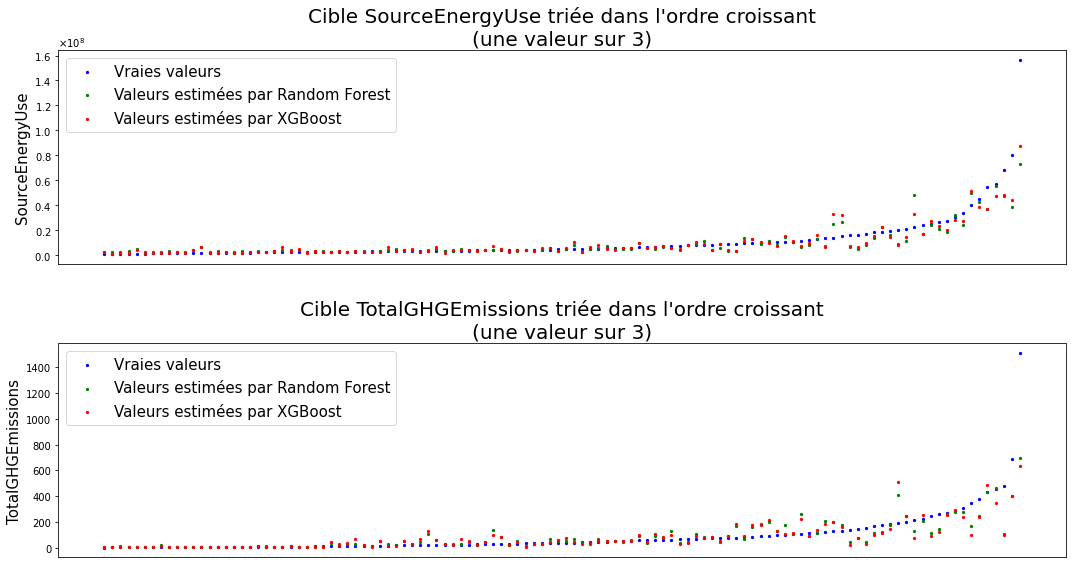

In [37]:
# graphiques d'affichage des valeurs exactes et prédites

fig = plt.figure(figsize=(15,8))
ax = plt.subplot(211)

nb_obs = raw_data.shape[0]

obs = zip(raw_energy,
          rf1.predict(raw_data.drop(columns=["ENERGYSTARScore"])),
          xgb1.predict(raw_data.drop(columns=["ENERGYSTARScore"])))
obs = sorted(obs, key=lambda x : x[0])

values = [obs[i] for i in range(0,nb_obs+1,3)]

ax.set_title("Cible SourceEnergyUse triée dans l'ordre croissant\n(une valeur sur 3)",
            fontsize=20)
ax.scatter(range(1,len(values)+1), [x[0] for x in values], c='b', s=5, label="Vraies valeurs")
ax.scatter(range(1,len(values)+1), [x[2] for x in values], c='g',s=5, label="Valeurs estimées par Random Forest")
ax.scatter(range(1,len(values)+1), [x[1] for x in values], c='r', s=5, label="Valeurs estimées par XGBoost")
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
ax.yaxis.set_major_formatter(formatter)
ax.set_xticks([])
ax.set_ylabel("SourceEnergyUse", fontsize=15)
ax.legend(fontsize=15)

ax = plt.subplot(212)

obs = zip(raw_emissions,
          rf2.predict(raw_data.drop(columns=["ENERGYSTARScore"])),
          xgb2.predict(raw_data.drop(columns=["ENERGYSTARScore"])))
obs = sorted(obs, key=lambda x : x[0])

values = [obs[i] for i in range(0,nb_obs+1,3)]

ax.set_title("\nCible TotalGHGEmissions triée dans l'ordre croissant\n(une valeur sur 3)",
            fontsize=20)
ax.scatter(range(1,len(values)+1), [x[0] for x in values], c='b', s=5, label="Vraies valeurs")
ax.scatter(range(1,len(values)+1), [x[2] for x in values], c='g',s=5, label="Valeurs estimées par Random Forest")
ax.scatter(range(1,len(values)+1), [x[1] for x in values], c='r', s=5, label="Valeurs estimées par XGBoost")
ax.set_xticks([])
ax.set_ylabel("TotalGHGEmissions", fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()
plt.savefig("Erreurs.png")

# Conclusion
Les performances sont équivalentes, les paramètres de XGBoost peuvent encore être optimisés.